In [18]:
print("Hello World!")

Hello World!


In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

#variables (hyperparameters, dir, etc.)
DATA_DIR = "../data/potato"
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_data_loaders(data_dir, batch_size=32, img_size=224): #data loading
    transform = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(img_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
    }

    #manual split of dataset (data/potato)
    full_dataset = datasets.ImageFolder(data_dir)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    train_dataset.dataset.transform = transform['train']
    val_dataset.dataset.transform = transform['val']

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, full_dataset.classes

In [ ]:
#main model setter
def get_model(num_classes):
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False

    #classifier
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )

    return model.to(DEVICE)

In [ ]:
def train_model(model, train_loader, val_loader, epochs, lr):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        #get model train loss + val loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    return model

In [ ]:
train_loader, val_loader, class_names = get_data_loaders(DATA_DIR, BATCH_SIZE, IMG_SIZE)
#model training
model = get_model(num_classes=len(class_names))
model = train_model(model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE)

/Users/john/programming/cnn/41079-research-project/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/john/programming/cnn/41079-research-project/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 49/49 [00:25<00:00,  1.95it/s]


Epoch 1: Train Loss = 1.7358, Val Loss = 1.3057


Epoch 2/10: 100%|██████████| 49/49 [00:23<00:00,  2.05it/s]


Epoch 2: Train Loss = 1.2129, Val Loss = 0.9091


Epoch 3/10: 100%|██████████| 49/49 [00:23<00:00,  2.10it/s]


Epoch 3: Train Loss = 0.9117, Val Loss = 0.6578


Epoch 4/10: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s]


Epoch 4: Train Loss = 0.7116, Val Loss = 0.5270


Epoch 5/10: 100%|██████████| 49/49 [00:23<00:00,  2.13it/s]


Epoch 5: Train Loss = 0.6100, Val Loss = 0.4444


Epoch 6/10: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s]


Epoch 6: Train Loss = 0.5384, Val Loss = 0.3933


Epoch 7/10: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s]


Epoch 7: Train Loss = 0.5015, Val Loss = 0.3547


Epoch 8/10: 100%|██████████| 49/49 [00:23<00:00,  2.12it/s]


Epoch 8: Train Loss = 0.4551, Val Loss = 0.3359


Epoch 9/10: 100%|██████████| 49/49 [00:22<00:00,  2.14it/s]


Epoch 9: Train Loss = 0.4140, Val Loss = 0.3070


Epoch 10/10: 100%|██████████| 49/49 [00:22<00:00,  2.14it/s]


Epoch 10: Train Loss = 0.3818, Val Loss = 0.2836


In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_model(model, val_loader, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    print(f"\n🔍 Accuracy: {acc * 100:.2f}%\n")

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix with Counts")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Number the matrix
    thresh = cm.max() / 2.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


🔍 Accuracy: 93.86%

Classification Report:
                       precision    recall  f1-score   support

          Black Scurf       0.64      0.78      0.70         9
             Blackleg       0.77      0.71      0.74        14
          Common Scab       0.70      0.64      0.67        11
              Dry Rot       0.70      0.70      0.70        10
     Healthy Potatoes       0.83      1.00      0.91        15
        Miscellaneous       0.80      0.62      0.70        13
             Pink Rot       0.80      0.73      0.76        11
Potato___Early_blight       0.98      1.00      0.99        84
 Potato___Late_blight       0.98      0.98      0.98       110
     Potato___healthy       1.00      0.99      1.00       114

             accuracy                           0.94       391
            macro avg       0.82      0.81      0.81       391
         weighted avg       0.94      0.94      0.94       391



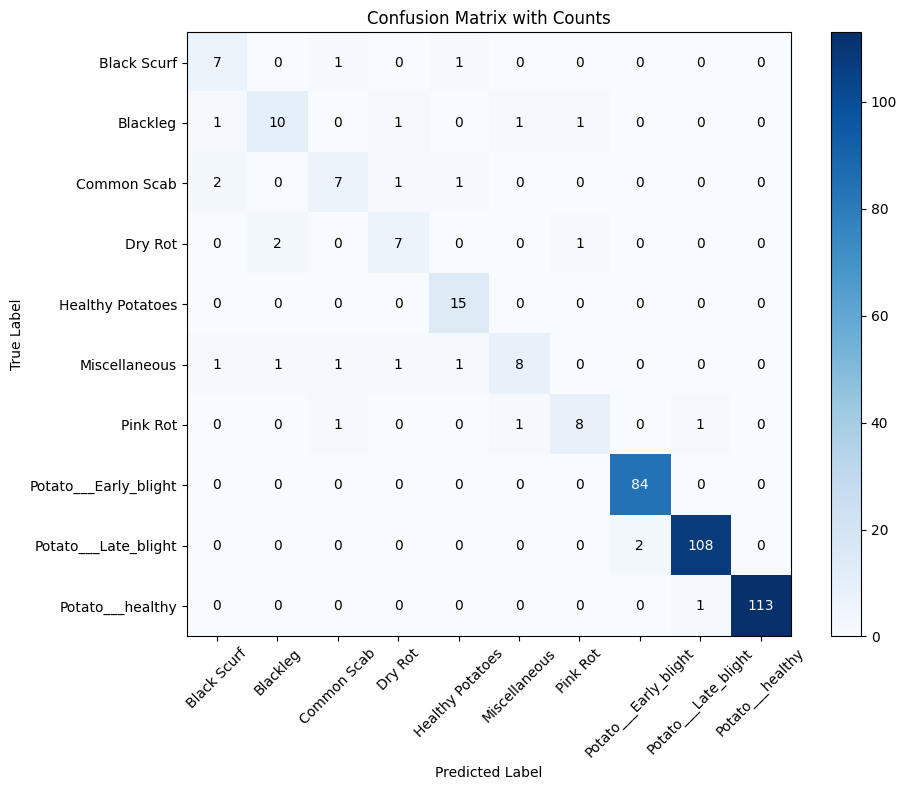

In [29]:
evaluate_model(model, val_loader, class_names)

In [31]:
torch.save(model.state_dict(), "models/potato_disease_classifier.pth")